In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

<Figure size 3600x3600 with 0 Axes>

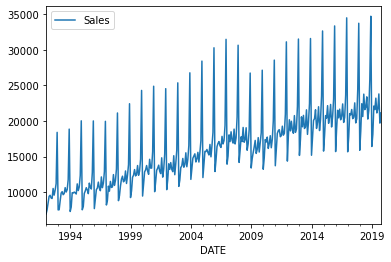

In [3]:
df.columns = ['Sales']
plt.figure(figsize=(50,50))
df.plot()

In [4]:
# Train Test Spliting

In [5]:
# We are considering 18 months for defining our pattern
# As data is given in month-wise
test_size = 18
test_ind = len(df)- test_size

In [6]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [8]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [9]:
# Normalizing Data

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler= MinMaxScaler()

In [12]:
scaler.fit(train)

MinMaxScaler()

In [13]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
# Time-Series Generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [16]:
# Model Creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [17]:
n_features = 1

In [18]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
# Early Stopping and Validation
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=2)

In [21]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [22]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\User\AppData\Local\Temp\ipykernel_8280\1350552164.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 2s 4ms/step - loss: 0.0253 - val_loss: 0.0026
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0026
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0037


<AxesSubplot:>

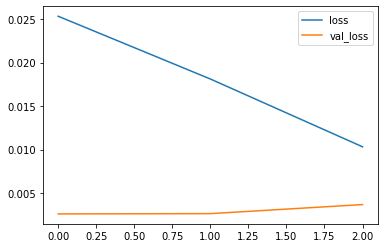

In [23]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [24]:
# Evaluatation on test Data

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [26]:
true_predictions = scaler.inverse_transform(test_predictions)

In [27]:
test['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_8280\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='DATE'>

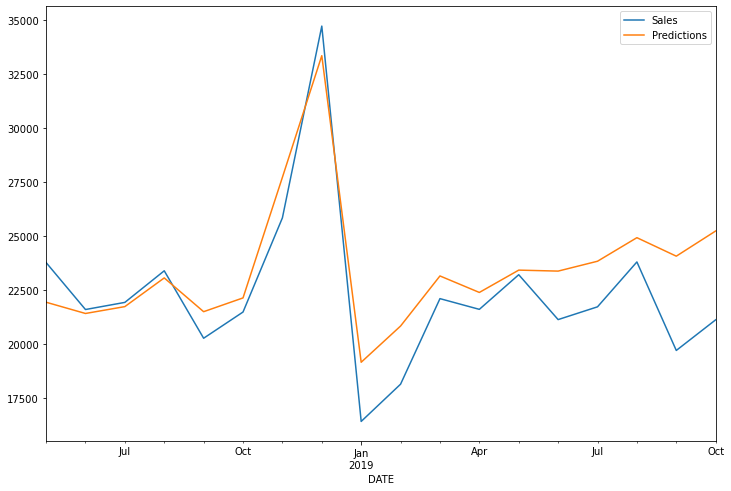

In [28]:
test.plot(figsize=(12,8))

In [29]:
# Retrain and Forecasting

In [30]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [31]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [32]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


C:\Users\User\AppData\Local\Temp\ipykernel_8280\853647718.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 2s 3ms/step - loss: 0.0219
Epoch 2/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0161
Epoch 3/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 4/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 5/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 6/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 7/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0014


In [40]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    print(i)
    print(current_pred)
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step
0
[0.68879557]
1/1 [==============================] - 0s 15ms/step
1
[1.088414]
1/1 [==============================] - 0s 17ms/step
2
[0.33336374]
1/1 [==============================] - 0s 16ms/step
3
[0.40347618]
1/1 [==============================] - 0s 16ms/step
4
[0.5390587]
1/1 [==============================] - 0s 15ms/step
5
[0.5261996]
1/1 [==============================] - 0s 15ms/step
6
[0.58299786]
1/1 [==============================] - 0s 15ms/step
7
[0.5110734]
1/1 [==============================] - 0s 15ms/step
8
[0.5352453]
1/1 [==============================] - 0s 16ms/step
9
[0.6068923]
1/1 [==============================] - 0s 15ms/step
10
[0.47065064]
1/1 [==============================] - 0s 15ms/step
11
[0.52029693]


In [34]:
forecast = scaler.inverse_transform(forecast)

In [35]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [36]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<AxesSubplot:>

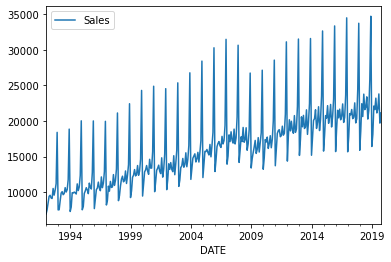

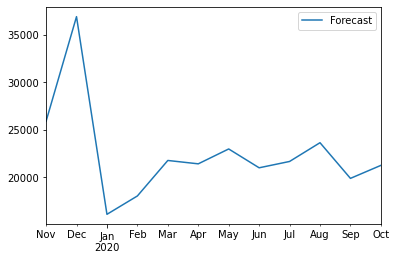

In [37]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

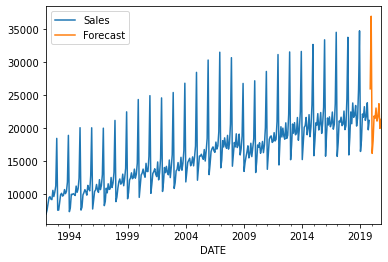

In [38]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

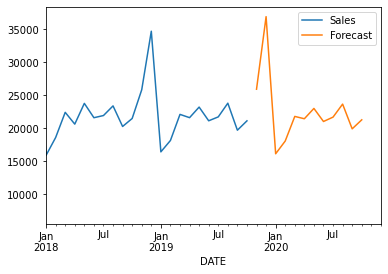

In [39]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')